<a href="https://colab.research.google.com/github/safdark/Automata-Capstone/blob/CarND-Object-Detection-Lab/object-detection-coco/CarND-Object-Detection-Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CarND Object Detection Lab

Let's get started!

In [1]:
! rm -r Object-detection-coco
! git clone https://github.com/bessszilard/Object-detection-coco

rm: cannot remove 'Object-detection-coco': No such file or directory
Cloning into 'Object-detection-coco'...
remote: Enumerating objects: 67, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 67 (delta 6), reused 61 (delta 4), pack-reused 0
Unpacking objects: 100% (67/67), done.


In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageDraw
from PIL import ImageColor
import time
from scipy.stats import norm

%matplotlib inline
plt.style.use('ggplot')

In [0]:
def vanilla_conv_block(x, kernel_size, output_channels):
    """
    Vanilla Conv -> Batch Norm -> ReLU
    """
    x = tf.layers.conv2d(
        x, output_channels, kernel_size, (2, 2), padding='SAME')
    x = tf.layers.batch_normalization(x)
    return tf.nn.relu(x)

# TODO: implement MobileNet conv block
def mobilenet_conv_block(x, kernel_size, output_channels):
    """
    Depthwise Conv -> Batch Norm -> ReLU -> Pointwise Conv -> Batch Norm -> ReLU
    """
    # assumes BHWC format
    input_channel_dim = x.get_shape().as_list()[-1] 
    W = tf.Variable(tf.truncated_normal((kernel_size, kernel_size, input_channel_dim, 1)))

    # depthwise conv
    x = tf.nn.depthwise_conv2d(x, W, (1, 2, 2, 1), padding='SAME')
    x = tf.layers.batch_normalization(x)
    x = tf.nn.relu(x)

    # pointwise conv
    x = tf.layers.conv2d(x, output_channels, (1, 1), padding='SAME')
    x = tf.layers.batch_normalization(x)
    return tf.nn.relu(x)

In [4]:
# constants but you can change them so I guess they're not so constant :)
INPUT_CHANNELS = 32
OUTPUT_CHANNELS = 512
KERNEL_SIZE = 3
IMG_HEIGHT = 256
IMG_WIDTH = 256

with tf.Session(graph=tf.Graph()) as sess:
    # input
    x = tf.constant(np.random.randn(1, IMG_HEIGHT, IMG_WIDTH, INPUT_CHANNELS), dtype=tf.float32)

    with tf.variable_scope('vanilla'):
        vanilla_conv = vanilla_conv_block(x, KERNEL_SIZE, OUTPUT_CHANNELS)
    with tf.variable_scope('mobile'):
        mobilenet_conv = mobilenet_conv_block(x, KERNEL_SIZE, OUTPUT_CHANNELS)

    vanilla_params = [
        (v.name, np.prod(v.get_shape().as_list()))
        for v in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'vanilla')
    ]
    mobile_params = [
        (v.name, np.prod(v.get_shape().as_list()))
        for v in tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'mobile')
    ]

    print("VANILLA CONV BLOCK")
    total_vanilla_params = sum([p[1] for p in vanilla_params])
    for p in vanilla_params:
        print("Variable {0}: number of params = {1}".format(p[0], p[1]))
    print("Total number of params =", total_vanilla_params)
    print()

    print("MOBILENET CONV BLOCK")
    total_mobile_params = sum([p[1] for p in mobile_params])
    for p in mobile_params:
        print("Variable {0}: number of params = {1}".format(p[0], p[1]))
    print("Total number of params =", total_mobile_params)
    print()

    print("{0:.3f}x parameter reduction".format(total_vanilla_params /
                                             total_mobile_params))

W0709 20:04:53.611470 140244889286528 deprecation.py:323] From <ipython-input-3-8486de148bd7>:6: conv2d (from tensorflow.python.layers.convolutional) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
W0709 20:04:53.621189 140244889286528 deprecation.py:506] From /usr/local/lib/python2.7/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling __init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0709 20:04:53.905117 140244889286528 deprecation.py:323] From <ipython-input-3-8486de148bd7>:7: batch_normalization (from tensorflow.python.layers.normalization) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDAT

VANILLA CONV BLOCK
Variable vanilla/conv2d/kernel:0: number of params = 147456
Variable vanilla/conv2d/bias:0: number of params = 512
Variable vanilla/batch_normalization/gamma:0: number of params = 512
Variable vanilla/batch_normalization/beta:0: number of params = 512
('Total number of params =', 148992)
()
MOBILENET CONV BLOCK
Variable mobile/Variable:0: number of params = 288
Variable mobile/batch_normalization/gamma:0: number of params = 32
Variable mobile/batch_normalization/beta:0: number of params = 32
Variable mobile/conv2d/kernel:0: number of params = 16384
Variable mobile/conv2d/bias:0: number of params = 512
Variable mobile/batch_normalization_1/gamma:0: number of params = 512
Variable mobile/batch_normalization_1/beta:0: number of params = 512
('Total number of params =', 18272)
()
8.000x parameter reduction


Your solution should show the majority of the parameters in *MobileNet* block stem from the pointwise convolution.

## Object Detection Inference

In this part of the lab you'll detect objects using pretrained object detection models. You can download the latest pretrained models from the [model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md), although do note that you may need a newer version of TensorFlow (such as v1.8) in order to use the newest models.

We are providing the download links for the below noted files to ensure compatibility between the included environment file and the models.

[SSD_Mobilenet 11.6.17 version](http://download.tensorflow.org/models/object_detection/ssd_mobilenet_v1_coco_11_06_2017.tar.gz)

[RFCN_ResNet101 11.6.17 version](http://download.tensorflow.org/models/object_detection/rfcn_resnet101_coco_11_06_2017.tar.gz)

[Faster_RCNN_Inception_ResNet 11.6.17 version](http://download.tensorflow.org/models/object_detection/faster_rcnn_inception_resnet_v2_atrous_coco_11_06_2017.tar.gz)

Make sure to extract these files prior to continuing!

In [5]:
! cd Object-detection-coco/; ls

assets				  exercise-solutions
CarND-Object-Detection-Lab.ipynb  LICENSE
driving.mp4			  README.md
env_cn.yml			  ssd_mobilenet_v1_coco_11_06_2017
environment.yml			  tf_images


In [0]:
# Frozen inference graph files. NOTE: change the path to where you saved the models.
SSD_GRAPH_FILE = 'Object-detection-coco/ssd_mobilenet_v1_coco_11_06_2017/frozen_inference_graph.pb'
RFCN_GRAPH_FILE = 'rfcn_resnet101_coco_11_06_2017/frozen_inference_graph.pb'
FASTER_RCNN_GRAPH_FILE = 'faster_rcnn_inception_resnet_v2_atrous_coco_11_06_2017/frozen_inference_graph.pb'

Below are utility functions. The main purpose of these is to draw the bounding boxes back onto the original image.

In [7]:
# Colors (one for each class)
cmap = ImageColor.colormap
print("Number of colors =", len(cmap))
COLOR_LIST = sorted([c for c in cmap.keys()])

#
# Utility funcs
#

def filter_boxes(min_score, boxes, scores, classes):
    """Return boxes with a confidence >= `min_score`"""
    n = len(classes)
    idxs = []
    for i in range(n):
        if scores[i] >= min_score:
            idxs.append(i)
    
    filtered_boxes = boxes[idxs, ...]
    filtered_scores = scores[idxs, ...]
    filtered_classes = classes[idxs, ...]
    return filtered_boxes, filtered_scores, filtered_classes

def to_image_coords(boxes, height, width):
    """
    The original box coordinate output is normalized, i.e [0, 1].
    
    This converts it back to the original coordinate based on the image
    size.
    """
    box_coords = np.zeros_like(boxes)
    box_coords[:, 0] = boxes[:, 0] * height
    box_coords[:, 1] = boxes[:, 1] * width
    box_coords[:, 2] = boxes[:, 2] * height
    box_coords[:, 3] = boxes[:, 3] * width
    
    return box_coords

def draw_boxes(image, boxes, classes, thickness=4):
    """Draw bounding boxes on the image"""
    draw = ImageDraw.Draw(image)
    for i in range(len(boxes)):
        bot, left, top, right = boxes[i, ...]
        class_id = int(classes[i])
        color = 'red' # COLOR_LIST[class_id]
        draw.line([(left, top), (left, bot), (right, bot), (right, top), (left, top)], width=thickness, fill=color)
#         print(color)
        
def load_graph(graph_file):
    """Loads a frozen inference graph"""
    graph = tf.Graph()
    with graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(graph_file, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return graph

('Number of colors =', 148)


Below we load the graph and extract the relevant tensors using [`get_tensor_by_name`](https://www.tensorflow.org/api_docs/python/tf/Graph#get_tensor_by_name). These tensors reflect the input and outputs of the graph, or least the ones we care about for detecting objects.

In [0]:
detection_graph = load_graph(SSD_GRAPH_FILE)
# detection_graph = load_graph(RFCN_GRAPH_FILE)
# detection_graph = load_graph(FASTER_RCNN_GRAPH_FILE)

# The input placeholder for the image.
# `get_tensor_by_name` returns the Tensor with the associated name in the Graph.
image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

# Each box represents a part of the image where a particular object was detected.
detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

# Each score represent how level of confidence for each of the objects.
# Score is shown on the result image, together with the class label.
detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')

# The classification of the object (integer id).
detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')

In [0]:
from PIL import Image
import requests
from io import BytesIO

response = requests.get('https://www.petmd.com/sites/default/files/over-active-dog-211592482.jpg')
img = Image.open(BytesIO(response.content))

Run detection and classification on a sample image.

(1, 600, 800, 3)


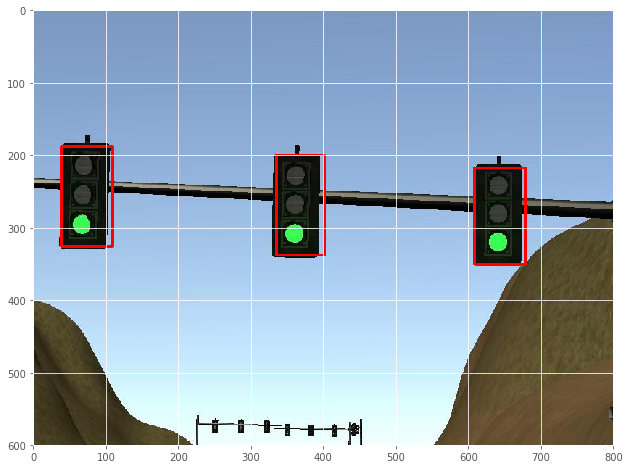

In [10]:
# Load a sample image.
# image = Image.open('./assets/sample1.jpg')
# image = Image.open('Object-detection-coco/assets/sample1.jpg')
image = Image.open('Object-detection-coco/tf_images/green-584.jpeg')
# image = img
image_np = np.expand_dims(np.asarray(image, dtype=np.uint8), 0)
print(image_np.shape)
with tf.Session(graph=detection_graph) as sess:                
    # Actual detection.
    (boxes, scores, classes) = sess.run([detection_boxes, detection_scores, detection_classes], 
                                        feed_dict={image_tensor: image_np})

    # Remove unnecessary dimensions
    boxes = np.squeeze(boxes)
    scores = np.squeeze(scores)
    classes = np.squeeze(classes)

    confidence_cutoff = 0.7
    # Filter boxes with a confidence score less than `confidence_cutoff`
    boxes, scores, classes = filter_boxes(confidence_cutoff, boxes, scores, classes)

    # The current box coordinates are normalized to a range between 0 and 1.
    # This converts the coordinates actual location on the image.
    width, height = image.size
    box_coords = to_image_coords(boxes, height, width)

    # Each class with be represented by a differently colored box
    draw_boxes(image, box_coords, classes)

    plt.figure(figsize=(12, 8))
    plt.imshow(image) 

## Timing Detection

The model zoo comes with a variety of models, each its benefits and costs. Below you'll time some of these models. The general tradeoff being sacrificing model accuracy for seconds per frame (SPF).

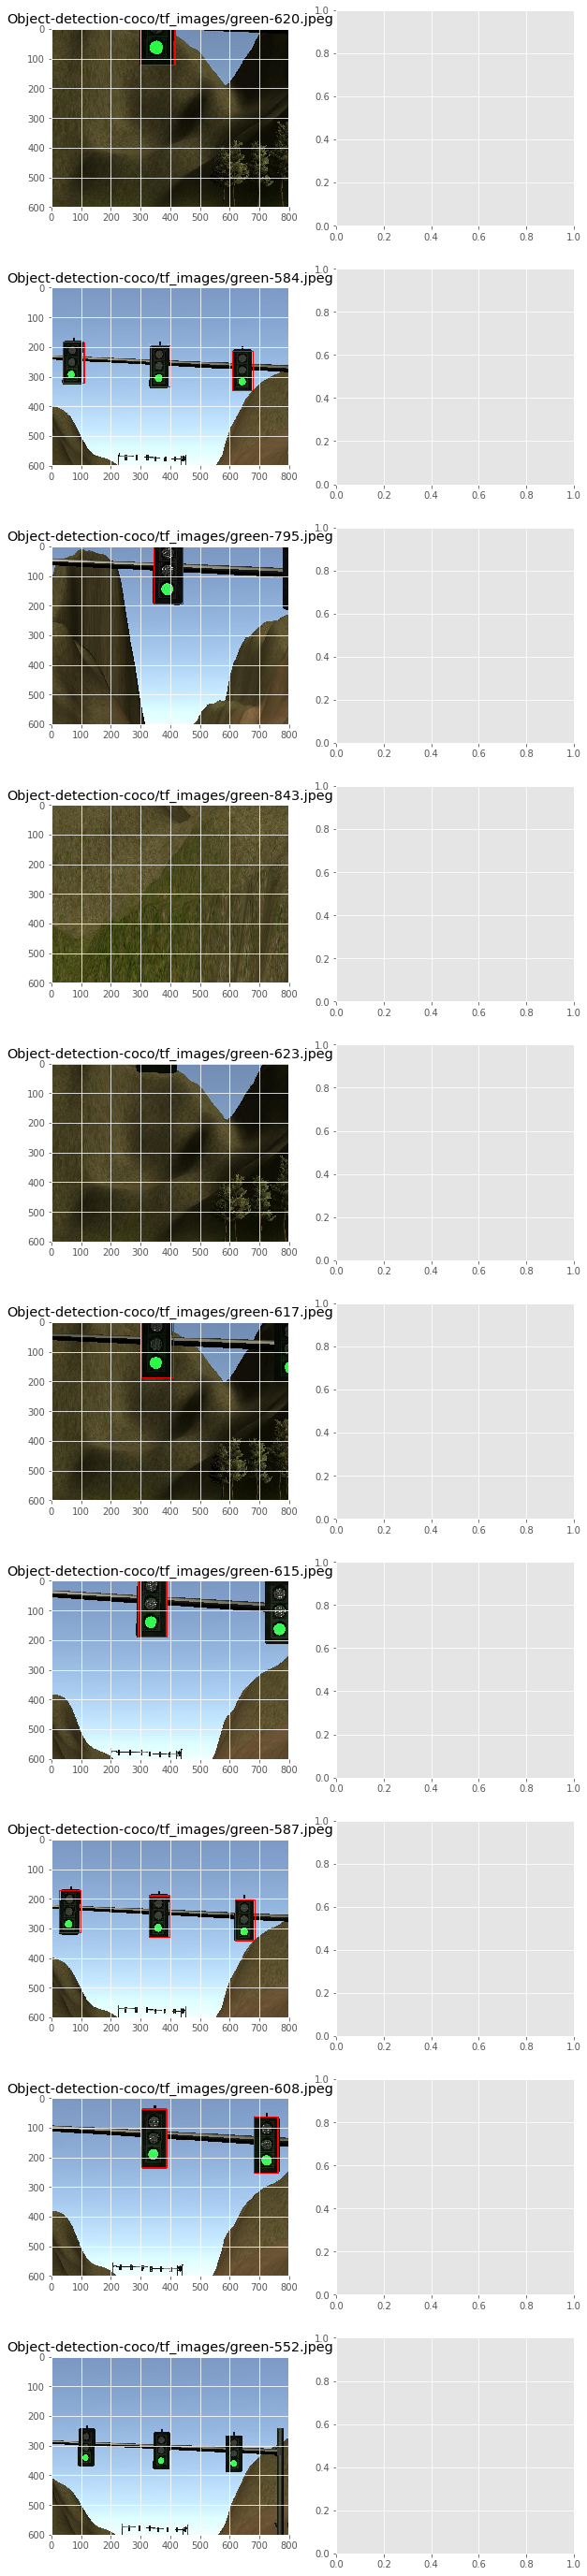

In [11]:
import glob
from pylab import *
%matplotlib inline

def pipeline(image):
    image_np = np.expand_dims(np.asarray(image, dtype=np.uint8), 0)
    with tf.Session(graph=detection_graph) as sess:                
        # Actual detection.
        (boxes, scores, classes) = sess.run([detection_boxes, detection_scores, detection_classes], 
                                            feed_dict={image_tensor: image_np})

        # Remove unnecessary dimensions
        boxes = np.squeeze(boxes)
        scores = np.squeeze(scores)
        classes = np.squeeze(classes)

        confidence_cutoff = 0.7
        # Filter boxes with a confidence score less than `confidence_cutoff`
        boxes, scores, classes = filter_boxes(confidence_cutoff, boxes, scores, classes)

        # The current box coordinates are normalized to a range between 0 and 1.
        # This converts the coordinates actual location on the image.
        width, height = image.size
        box_coords = to_image_coords(boxes, height, width)

        # Each class with be represented by a differently colored box
        draw_boxes(image, box_coords, classes)
        return(image) 

    
image_file_names = glob.glob('Object-detection-coco/tf_images/green-*.jpeg')
# print(image_file_names)

# for i in range(row):
#     image_file = image_file_names[i]
#     image = Image.open(image_file_names[i])
#     image = pipeline(image)
    
#     plt.figure(figsize=(12, 8))
#     plt.imshow(image)

rows = 10
f, ax = subplots(rows, 2, figsize=(10, 50))
for i in range(rows):
    image_file = image_file_names[i]
    image = Image.open(image_file_names[i])
    image = pipeline(image)
    
    ax[i][0].imshow(image)
    ax[i][0].set_title(image_file_names[i])
#     plt.figure(figsize=(12, 8))
#     plt.imshow(image)
    

In [0]:
# def time_detection(sess, img_height, img_width, runs=10):
#     image_tensor = sess.graph.get_tensor_by_name('image_tensor:0')
#     detection_boxes = sess.graph.get_tensor_by_name('detection_boxes:0')
#     detection_scores = sess.graph.get_tensor_by_name('detection_scores:0')
#     detection_classes = sess.graph.get_tensor_by_name('detection_classes:0')

#     # warmup
#     gen_image = np.uint8(np.random.randn(1, img_height, img_width, 3))
#     sess.run([detection_boxes, detection_scores, detection_classes], feed_dict={image_tensor: gen_image})
    
#     times = np.zeros(runs)
#     for i in range(runs):
#         t0 = time.time()
#         sess.run([detection_boxes, detection_scores, detection_classes], feed_dict={image_tensor: image_np})
#         t1 = time.time()
#         times[i] = (t1 - t0) * 1000
#     return times

In [0]:
# with tf.Session(graph=detection_graph) as sess:
#     times = time_detection(sess, 600, 1000, runs=10)

In [0]:
# # Create a figure instance
# fig = plt.figure(1, figsize=(9, 6))

# # Create an axes instance
# ax = fig.add_subplot(111)
# plt.title("Object Detection Timings")
# plt.ylabel("Time (ms)")

# # Create the boxplot
# plt.style.use('fivethirtyeight')
# bp = ax.boxplot(times)

### Exercise 4 - Model Tradeoffs

Download a few models from the [model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) and compare the timings.

## Detection on a Video

Finally run your pipeline on [this short video](https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/advanced_deep_learning/driving.mp4).

In [0]:
# # Import everything needed to edit/save/watch video clips
# from moviepy.editor import VideoFileClip
# from IPython.display import HTML

In [0]:
# HTML("""
# <video width="960" height="600" controls>
#   <source src="{0}" type="video/mp4">
# </video>
# """.format('driving.mp4'))

### Exercise 5 - Object Detection on a Video

Run an object detection pipeline on the above clip.

In [0]:
# clip = VideoFileClip('Object-detection-coco/driving.mp4')

In [0]:
# # TODO: Complete this function.
# # The input is an NumPy array.
# # The output should also be a NumPy array.
# def pipeline(img):
#     draw_img = Image.fromarray(img)
#     boxes, scores, classes = sess.run([detection_boxes, detection_scores, detection_classes], feed_dict={image_tensor: np.expand_dims(img, 0)})
#     # Remove unnecessary dimensions
#     boxes = np.squeeze(boxes)
#     scores = np.squeeze(scores)
#     classes = np.squeeze(classes)

#     confidence_cutoff = 0.8
#     # Filter boxes with a confidence score less than `confidence_cutoff`
#     boxes, scores, classes = filter_boxes(confidence_cutoff, boxes, scores, classes)

#     # The current box coordinates are normalized to a range between 0 and 1.
#     # This converts the coordinates actual location on the image.
#     width, height = draw_img.size
#     box_coords = to_image_coords(boxes, height, width)

#     # Each class with be represented by a differently colored box
#     draw_boxes(draw_img, box_coords, classes)
#     return np.array(draw_img)

**[Sample solution](./exercise-solutions/e5.py)**

In [0]:
# !git clone https://github.com/tensorflow/models
# !cd models/research/; ls -all
# !echo PYTHONPATH
# !python models/research/setup.py build; python models/research/setup.py install;


In [0]:
# !pwd
# !curl https://hci.iwr.uni-heidelberg.de/system/files/private/datasets/470246335/dataset_additional_rgb.zip

In [0]:
# this is based on https://github.com/swirlingsand/deeper-traffic-lights/blob/master/data_conversion_bosch.py

# import sys
# sys.path.append("models/research")
# sys.path.append("models/research/object_detection/utils")
                
# import tensorflow as tf
# import yaml
# import os
# from object_detection.utils import dataset_util


# flags = tf.app.flags
# # flags.DEFINE_string('output_path', '', 'Path to output TFRecord')
# flags.DEFINE_string('output_path', '', 'Path to output TFRecord')
# FLAGS = flags.FLAGS

# LABEL_DICT =  {
#     "Green" : 1,
#     "Red" : 2,
#     "GreenLeft" : 3,
#     "GreenRight" : 4,
#     "RedLeft" : 5,
#     "RedRight" : 6,
#     "Yellow" : 7,
#     "off" : 8,
#     "RedStraight" : 9,
#     "GreenStraight" : 10,
#     "GreenStraightLeft" : 11,
#     "GreenStraightRight" : 12,
#     "RedStraightLeft" : 13,
#     "RedStraightRight" : 14
#     }

# def create_tf_example(example):
    
#     # Bosch
#     height = 720 # Image height
#     width = 1280 # Image width

#     filename = example['path'] # Filename of the image. Empty if image is not from file
#     filename = filename.encode()

#     with tf.gfile.GFile(example['path'], 'rb') as fid:
#         encoded_image = fid.read()

#     image_format = 'png'.encode() 

#     xmins = [] # List of normalized left x coordinates in bounding box (1 per box)
#     xmaxs = [] # List of normalized right x coordinates in bounding box
#                 # (1 per box)
#     ymins = [] # List of normalized top y coordinates in bounding box (1 per box)
#     ymaxs = [] # List of normalized bottom y coordinates in bounding box
#                 # (1 per box)
#     classes_text = [] # List of string class name of bounding box (1 per box)
#     classes = [] # List of integer class id of bounding box (1 per box)

#     for box in example['boxes']:
#         #if box['occluded'] is False:
#         #print("adding box")
#         xmins.append(float(box['x_min'] / width))
#         xmaxs.append(float(box['x_max'] / width))
#         ymins.append(float(box['y_min'] / height))
#         ymaxs.append(float(box['y_max'] / height))
#         classes_text.append(box['label'].encode())
#         classes.append(int(LABEL_DICT[box['label']]))


#     tf_example = tf.train.Example(features=tf.train.Features(feature={
#         'image/height': dataset_util.int64_feature(height),
#         'image/width': dataset_util.int64_feature(width),
#         'image/filename': dataset_util.bytes_feature(filename),
#         'image/source_id': dataset_util.bytes_feature(filename),
#         'image/encoded': dataset_util.bytes_feature(encoded_image),
#         'image/format': dataset_util.bytes_feature(image_format),
#         'image/object/bbox/xmin': dataset_util.float_list_feature(xmins),
#         'image/object/bbox/xmax': dataset_util.float_list_feature(xmaxs),
#         'image/object/bbox/ymin': dataset_util.float_list_feature(ymins),
#         'image/object/bbox/ymax': dataset_util.float_list_feature(ymaxs),
#         'image/object/class/text': dataset_util.bytes_list_feature(classes_text),
#         'image/object/class/label': dataset_util.int64_list_feature(classes),
#     }))

#     return tf_example


# def main(_):
    
#     writer = tf.python_io.TFRecordWriter(FLAGS.output_path)
    
#     # BOSCH
#     INPUT_YAML = "data/test-bosch/dataset_test_rgb/test.yaml"
#     examples = yaml.load(open(INPUT_YAML, 'rb').read())

#     #examples = examples[:10]  # for testing
#     len_examples = len(examples)
#     print("Loaded ", len(examples), "examples")

#     for i in range(len(examples)):
#         examples[i]['path'] = os.path.abspath(os.path.join(os.path.dirname(INPUT_YAML), examples[i]['path']))
    
#     counter = 0
#     for example in examples:
#         tf_example = create_tf_example(example)
#         writer.write(tf_example.SerializeToString())

#         if counter % 10 == 0:
#             print("Percent done", (counter/len_examples)*100)
#         counter += 1

#     writer.close()